In [1]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from scipy.signal import find_peaks
import time
import sounddevice as sd
import noisereduce as nr
from spectrogram import Spectogram

In [2]:
spect = Spectogram(linewidth=2, time_step=0.05)

In [3]:
trange = np.arange(0,3,spect.sampling_dt)
O = 440 #Hz
spect.set(np.cos(2*np.pi*O*trange))

In [4]:
kmax, numax, maxval = spect.find_maxima_in_spectrum(0, threshold=2e-4)[0]
print(f'precision of maximum = {100*(numax-O)/O:.2f}%')

precision of maximum = -0.06%


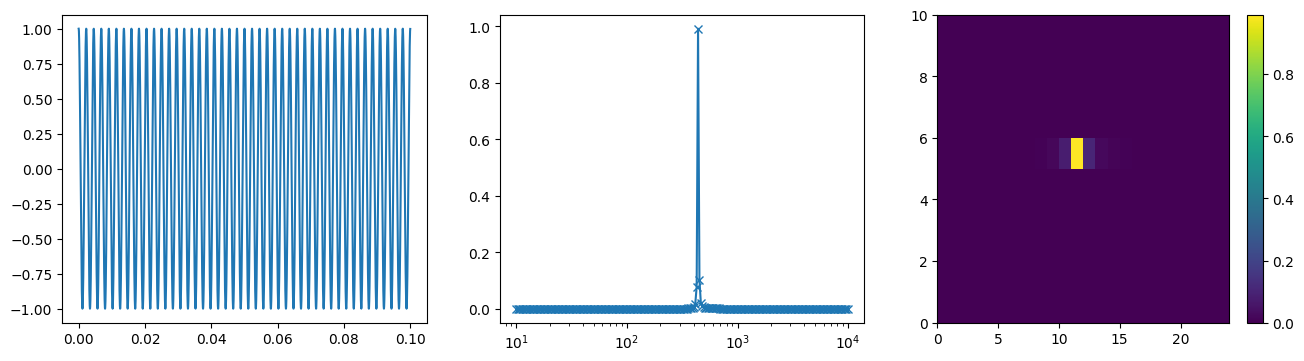

In [5]:
t = 0
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16,4))
sample = spect.data_slice(t, t+spect.tint)
times = np.arange(t, t+spect.tint,1/spect.sample_rate)
ax[0].plot(times, sample)
spect.plot_spectrum(t, ax=ax[1], marker='x')
mesh = spect.plot_octaves_2D(t, ax=ax[2], cmap='viridis')
fig.colorbar(mesh, ax=ax[2])
plt.show()

In [6]:
data, sample_rate = sf.read("output_audio.wav")
data = np.sum(data, axis=1)
data.shape

(3048448,)

<Axes: >

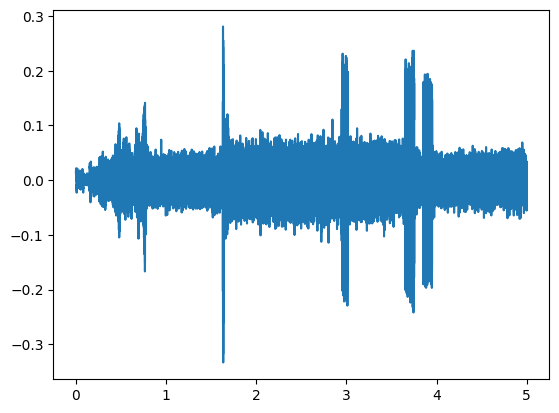

In [7]:
t1 = 18 #sec
t2 = 23 #spect.maxtime
sample = spect.data_slice(t1,t2, data)
spect.set(sample)
spect.plot_data()
#plt.plot(t1+ np.arange(len(sample))/spect.sample_rate, sample)

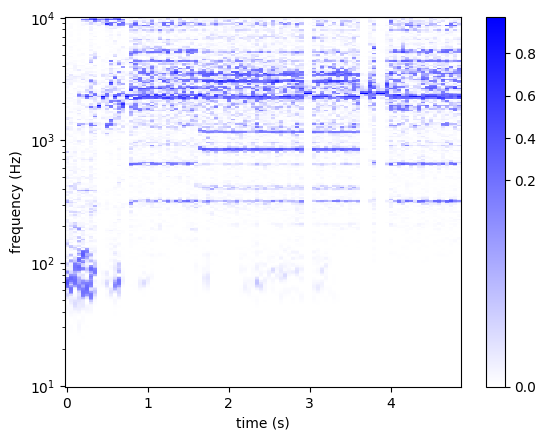

In [8]:
fig, ax = plt.subplots()
mesh = spect.show_spectrogram(ax=ax)
fig.colorbar(mesh, ax=ax)
plt.show()

In [9]:
spect.play()

<Axes: >

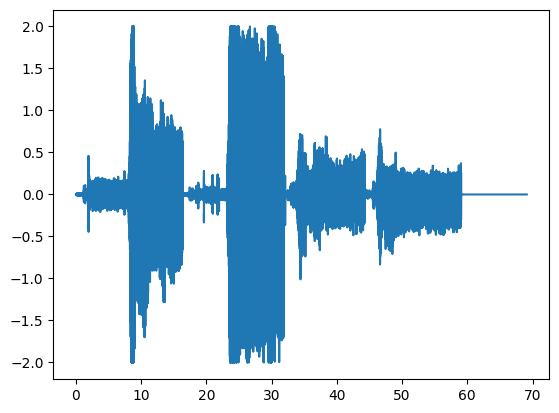

In [10]:
spect.set(data)
spect.plot_data()

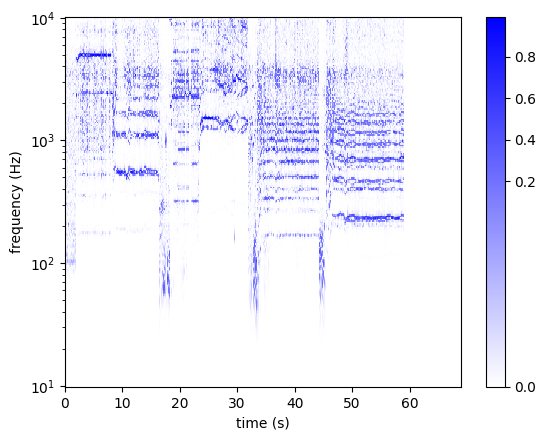

In [11]:
fig, ax = plt.subplots()
mesh = spect.show_spectrogram(ax=ax)
fig.colorbar(mesh, ax=ax)
plt.show()

maximum = 526.23 Hz


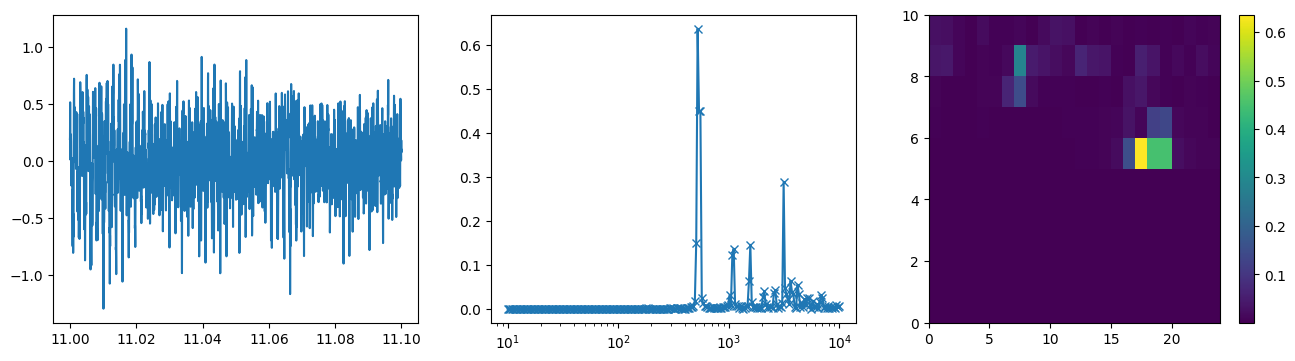

In [12]:
t = 11
kmax, numax, vmax = spect.find_maxima_in_spectrum(t)[0]
print(f'maximum = {numax:.2f} Hz')
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16,4))
sample = spect.data_slice(t, t+spect.tint)
times = np.linspace(t, t+spect.tint,len(sample))
ax[0].plot(times, sample)
spect.plot_spectrum(t, ax=ax[1], marker='x')
mesh = spect.plot_octaves_2D(t, ax=ax[2], cmap='viridis')
fig.colorbar(mesh, ax=ax[2])
plt.show()

In [13]:
spect.spectrum_data.shape

(1381, 240)

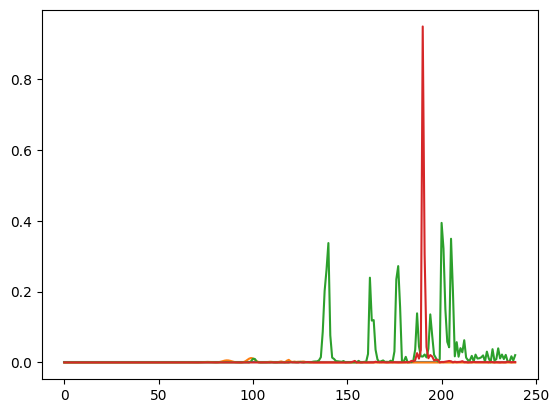

In [14]:
plt.plot(spect.spectrum_data[-1,:])
plt.plot(spect.spectrum_data[0])
plt.plot(spect.spectrum_data[int(12/spect.timestep)])
plt.plot(spect.spectrum_data[int(21/spect.timestep)])

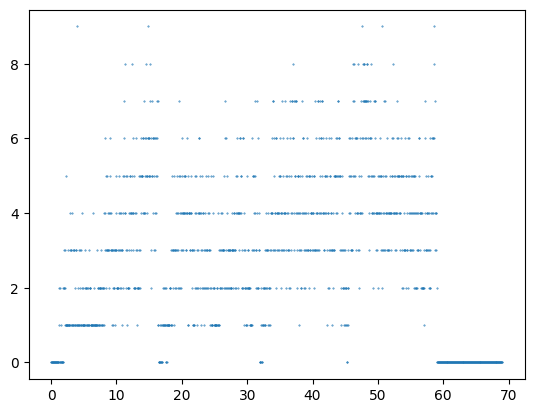

In [19]:
threshold = 0.2
times, peaks = spect.find_maxima_in_spectrogram(threshold=threshold)
plt.plot(times, [len(v) for v in peaks], 'o', ms=0.4)


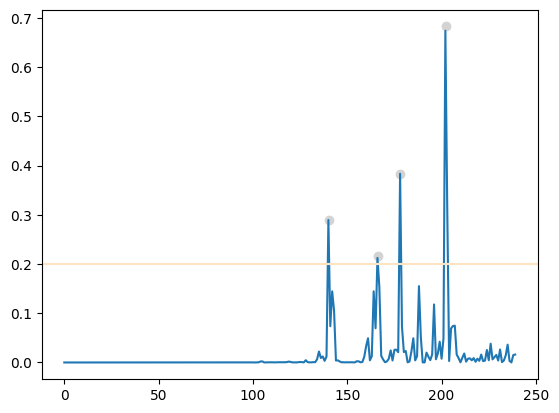

In [21]:
t = 14
n = spect.time_to_index(1/spect.timestep, t)
plt.plot(spect.spectrum_data[n])
plt.axhline(threshold,color='bisque')
for pos, freq, height in peaks[n]:
    plt.scatter(pos, height, color='lightgrey')

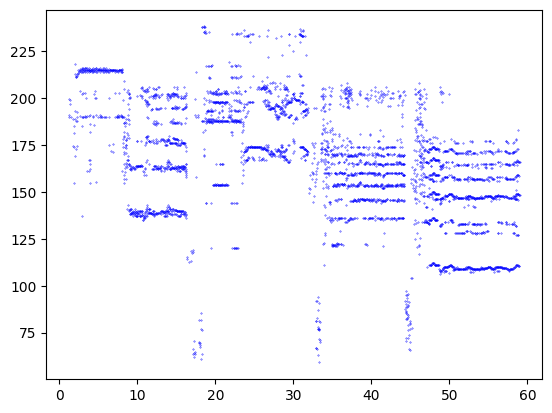

In [41]:
for i,p in enumerate(peaks):
    if len(p)==0:
        continue
    t = times[i]
    plt.plot(t*np.ones(shape=p.shape[0]), p[:,0], 'o', color='blue', ms=0.3)

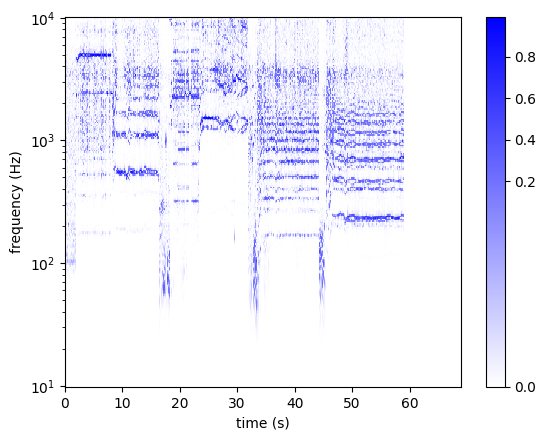

In [42]:
fig, ax = plt.subplots()
mesh = spect.show_spectrogram(ax=ax)
fig.colorbar(mesh, ax=ax)
plt.show()

In [55]:
tstart=10
tend  =16
tolerance=3
nstart,nend = spect.time_to_index(1/spect.timestep,tstart,tend)
trackers = [ [[nstart, int(u), float(v)]] for u,_,v in peaks[nstart]]
for timeindex in range(nstart+1, nend):
    for u,_,v in peaks[timeindex]:
        newitem = [timeindex, int(u), float(v)]
        foundtracker = False
        for i,tr in enumerate(trackers):
            if np.abs(tr[-1][1]-u)<tolerance:
                foundtracker=True
                trackers[i].append(newitem)
        if not foundtracker:
            trackers.append([newitem])
len(trackers)


34

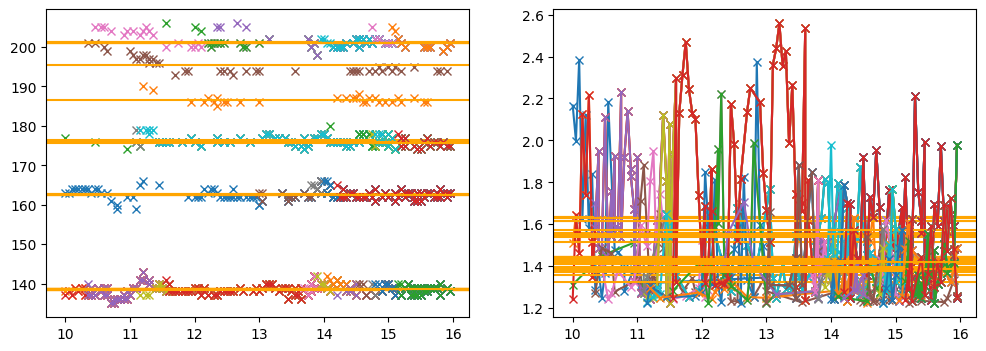

In [56]:
fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

for tracker in trackers:
    times, freqs, heights = np.array(tracker).T
    times = spect.timestep*times
    freqmean = np.mean(freqs)
    heightmean = np.mean(np.exp(heights))

    ax[0].plot(times, freqs, 'x')#, color='tab:blue')
    ax[0].axhline(freqmean, color='orange')
    ax[1].plot(times, np.exp(heights),'x-')
    ax[1].axhline(heightmean, color='orange')

In [57]:
trackerlens = [len(tr) for tr in trackers]
trackerfreqs = [np.mean(np.array(tr)[:,1]) for tr in trackers]
sorted_indices = np.argsort(trackerfreqs)
stable_tracks = [trackers[sorted_indices[0]].copy()]
stable_tracksfreqs = [trackerfreqs[sorted_indices[0]].copy()]
stable_tracksindex = [[sorted_indices[0]]]
tolerance = 2.5
for i in sorted_indices[1:]:
    if np.abs(trackerfreqs[i]-stable_tracksfreqs[-1])<tolerance:
        stable_tracks[-1].extend(trackers[i].copy())
        stable_tracks[-1] = sorted(stable_tracks[-1], key= lambda x: x[0])
        stable_tracksfreqs[-1] = np.mean(np.array(stable_tracks[-1])[:,1])
        stable_tracksindex[-1].append(i)
    else:
        stable_tracks.append(trackers[i].copy())
        stable_tracksfreqs.append(np.mean(np.array(stable_tracks[-1])[:,1]))
        stable_tracksindex.append([i])




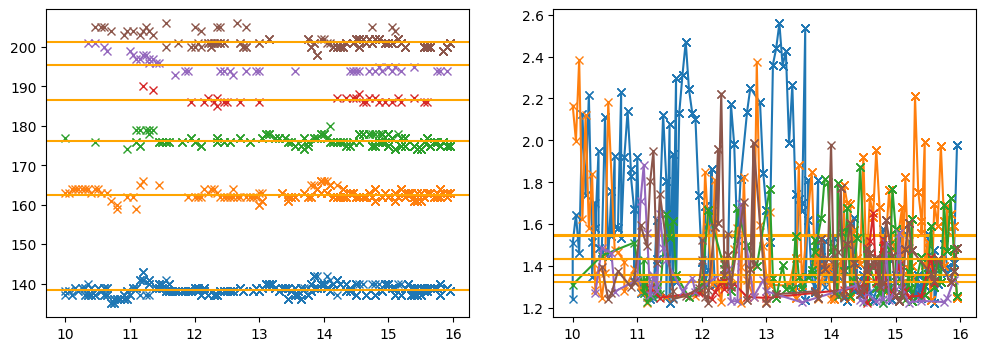

In [58]:
fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

for tracker in stable_tracks:
    times, freqs, heights = np.array(tracker).T
    if len(times) < 5:
        continue
    times = spect.timestep*times
    freqmean = np.mean(freqs)
    heightmean = np.mean(np.exp(heights))

    ax[0].plot(times, freqs, 'x')#, color='tab:blue')
    ax[0].axhline(freqmean, color='orange')
    ax[1].plot(times, np.exp(heights),'x-')
    ax[1].axhline(heightmean, color='orange')

In [59]:
U = np.array([spect.frequencies[int(i)] for i in np.array(stable_tracksfreqs)])
U/U[0]

array([1.        , 2.        , 2.99661415, 4.        , 5.18735822,
       6.1688433 ])

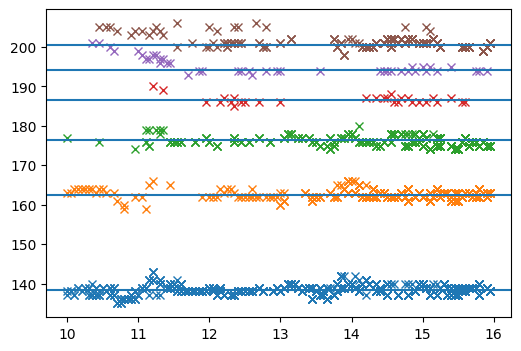

In [60]:
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4))

for tracker in stable_tracks:
    times, freqs, heights = np.array(tracker).T
    if len(times) < 5:
        continue
    times = spect.timestep*times
    freqmean = np.mean(freqs)
    heightmean = np.mean(np.exp(heights))

    ax.plot(times, freqs, 'x')#, color='tab:blue')
    #ax.axhline(freqmean, color='orange')
for n in range(1,7):
    ax.axhline(stable_tracksfreqs[0] + spect.Noctave*np.log(n)/np.log(2))

(array([ 9., 66., 69.,  9.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         2., 10., 71., 23.,  4.,  0.,  0.,  0.,  5., 17., 45., 19.,  1.,
         0.,  0., 16., 11.,  2.,  0.,  2., 25.,  7.,  4., 22., 35., 10.,
        12.]),
 array([135.   , 136.775, 138.55 , 140.325, 142.1  , 143.875, 145.65 ,
        147.425, 149.2  , 150.975, 152.75 , 154.525, 156.3  , 158.075,
        159.85 , 161.625, 163.4  , 165.175, 166.95 , 168.725, 170.5  ,
        172.275, 174.05 , 175.825, 177.6  , 179.375, 181.15 , 182.925,
        184.7  , 186.475, 188.25 , 190.025, 191.8  , 193.575, 195.35 ,
        197.125, 198.9  , 200.675, 202.45 , 204.225, 206.   ]),
 <BarContainer object of 40 artists>)

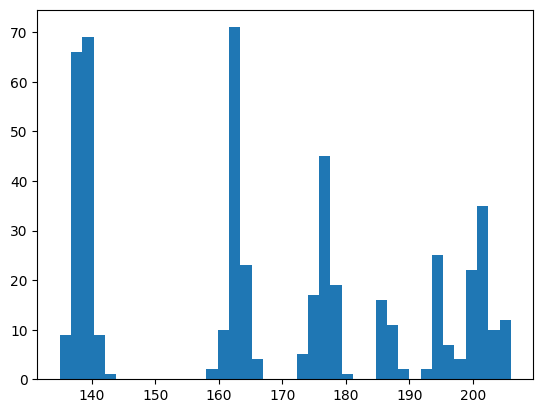

In [61]:
data = []
#for i in range(nstart,nend):
for i in range(nstart,nend):
    for u in peaks[i][:,0]:
        data.append(int(u))
plt.hist(data, bins=40)


In [ ]:
STOP HERE

SyntaxError: invalid syntax (3031286301.py, line 1)

553.9433990439317 538.1737057623773
139 115 138


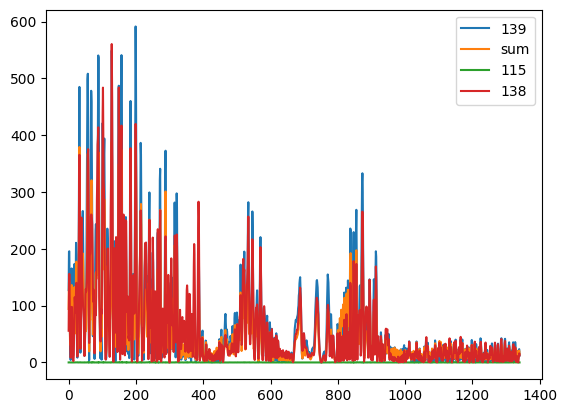

In [ ]:
maxindex1 = np.argmax(allspectra[30])
maxindex2 = np.argmax(allspectra[50])
plt.plot(allspectra[:,maxindex1], label=maxindex1)
plt.plot(np.sum(allspectra[:,138:142], axis=1)/4, label='sum')
plt.plot(allspectra[:,maxindex1-24], label=maxindex1-24)
plt.plot(allspectra[:,maxindex2], label=maxindex2)
print(logspectrum.omega[maxindex1], logspectrum.omega[maxindex2])
print(maxindex1,maxindex1-24,maxindex2)
plt.legend()
plt.show()

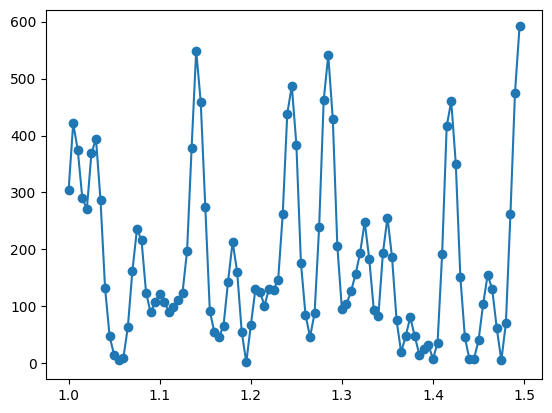

In [ ]:
plt.plot(np.arange(100,200)*dt + 100*dt, allspectra[100:200,maxindex1], marker='o')

In [ ]:
i0 = 0
octaves = np.array([ np.sum(allspectra[:,np.arange(i0, len(logspectrum.omega), logspectrum.Noctave)], axis=1) for i0 in range(logspectrum.Noctave)])
sumoctave = np.sum(octaves, axis =0)
octaves.shape, sumoctave.shape

((24, 1341), (1341,))

np.int64(10)

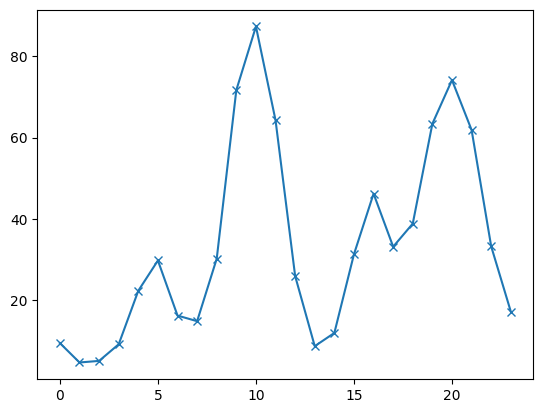

In [ ]:
ntime = 400
plt.plot(octaves[:,ntime], marker='x')
octavemax = np.argmax(octaves[:,ntime])
octavemax


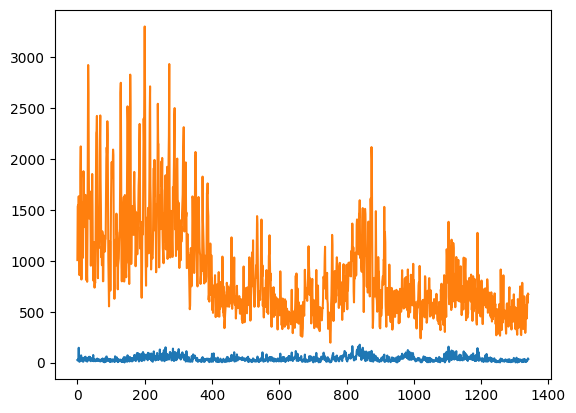

In [ ]:
plt.plot(octaves[octavemax,:])
plt.plot(sumoctave[:])

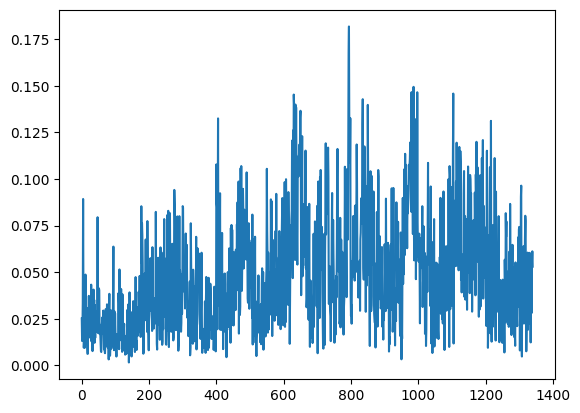

In [ ]:
plt.plot(octaves[octavemax,:]/sumoctave[:])

In [ ]:
mus = np.mean(allspectra,   axis=0)
sigmas = np.std(allspectra, axis=0)

Text(0.5, 1.0, 'spectrum variance')

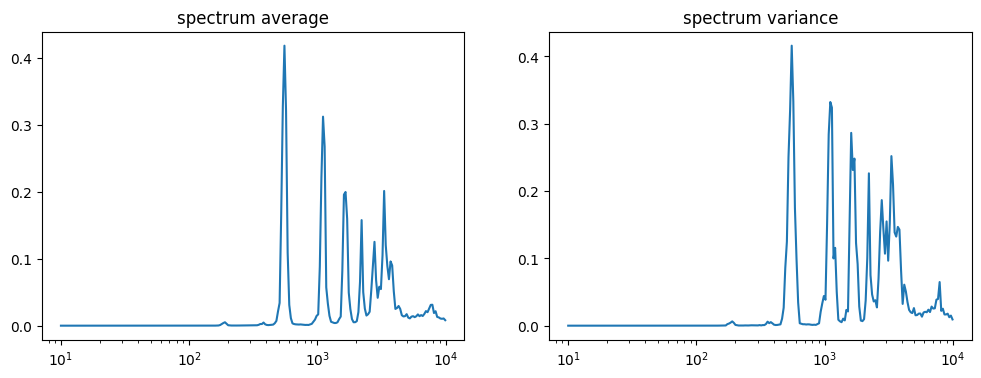

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(12,4))
ax[0].plot(logspectrum.omega, mus)
ax[0].set_xscale('log')
ax[0].set_title('spectrum average')
ax[1].plot(logspectrum.omega, sigmas)
ax[1].set_xscale('log')
ax[1].set_title('spectrum variance')

In [ ]:
peaks_position, _ = find_peaks(sigmas)
peaks = np.array([logspectrum.omega[peaks_position], sigmas[peaks_position],peaks_position]).T
sorted_peaks = peaks[peaks[:, 1].argsort()][::-1]
sorted_peaks = np.array([sorted_peaks[:,2], sorted_peaks[:,0], np.log(sorted_peaks[:,1]/sorted_peaks[0,1])/np.log(10)]).T
for q in sorted_peaks[:15]:
    print(f'index={int(q[0]):4d}, frequency={q[1]:.2f}, relative log height={q[2]:.3f}')

index= 139, frequency=553.94, relative log height=0.000
index= 163, frequency=1107.89, relative log height=-0.098
index= 176, frequency=1612.70, relative log height=-0.162
index= 201, frequency=3319.91, relative log height=-0.218
index= 178, frequency=1708.60, relative log height=-0.224
index= 187, frequency=2215.77, relative log height=-0.264
index= 195, frequency=2791.70, relative log height=-0.348
index= 198, frequency=3044.37, relative log height=-0.429
index= 205, frequency=3726.47, relative log height=-0.453
index= 166, frequency=1208.16, relative log height=-0.556
index= 231, frequency=7896.12, relative log height=-0.807
index= 209, frequency=4182.82, relative log height=-0.835
index= 159, frequency=987.01, relative log height=-0.975
index= 191, frequency=2487.12, relative log height=-1.042
index= 226, frequency=6834.38, relative log height=-1.166


In [ ]:
i = 139
omega_base = logspectrum.omega[i]
selection_value = np.median(allspectra[:,i])
selected_spectra = np.array([ s for s in allspectra if s[i] < selection_value])
mus_ratio = mus/(1e-6 + np.mean(selected_spectra,   axis=0))
mus_ratio[i-2:i+2] = 0
sigmas_ratio = sigmas/(1e-6 + np.std(selected_spectra, axis=0))
sigmas_ratio[i-2:i+2] = 0
omega_base


np.float64(553.9433990439317)

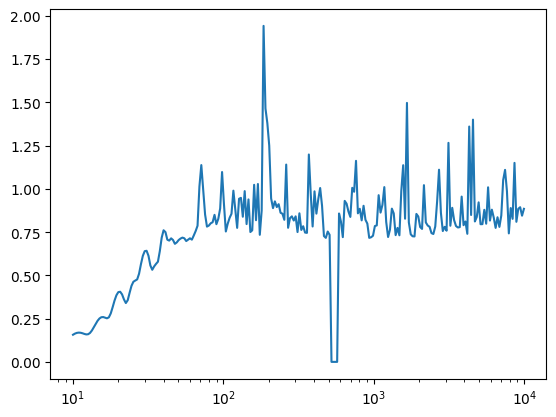

In [ ]:
plt.plot(logspectrum.omega, sigmas_ratio)
plt.xscale('log')

In [ ]:
peaks_position, _ = find_peaks(mus_ratio)
peaks = np.array([logspectrum.omega[peaks_position], mus_ratio[peaks_position]]).T
sorted_peaks = peaks[peaks[:, 1].argsort()][::-1]
sorted_peaks = np.array([omega_base/sorted_peaks[:,0], np.log(sorted_peaks[:,1]/sorted_peaks[0,1])/np.log(10)]).T
sorted_peaks[:15]

array([[ 2.99661415,  0.        ],
       [ 0.33370996, -0.06902985],
       [ 1.49830708, -0.07915701],
       [ 3.46214624, -0.14536108],
       [ 3.26783091, -0.15974455],
       [ 4.        , -0.1653277 ],
       [ 0.74915354, -0.1969013 ],
       [ 1.25992105, -0.19705982],
       [ 7.77225553, -0.20352082],
       [ 5.0396842 , -0.22153306],
       [ 4.23785238, -0.22766191],
       [ 3.77549725, -0.23216142],
       [ 0.12866278, -0.23381363],
       [ 0.20423943, -0.24005092],
       [ 0.68697682, -0.24065152]])

In [ ]:
STOP HERE

SyntaxError: invalid syntax (3031286301.py, line 1)

In [ ]:
data, sample_rate = sf.read("szolnok/2025_02_25-17_29_47.wav")
data = np.sum(data, axis=1)
data.shape

LibsndfileError: Error opening 'szolnok/2025_02_25-17_29_47.wav': System error.

In [ ]:
logspectrum.set(data) #.play()
print(f'maximal time t_max = {logspectrum.maxtime:.2f} sec')

maximal time t_max = 32.13 sec


precision of maximum = -25.10%


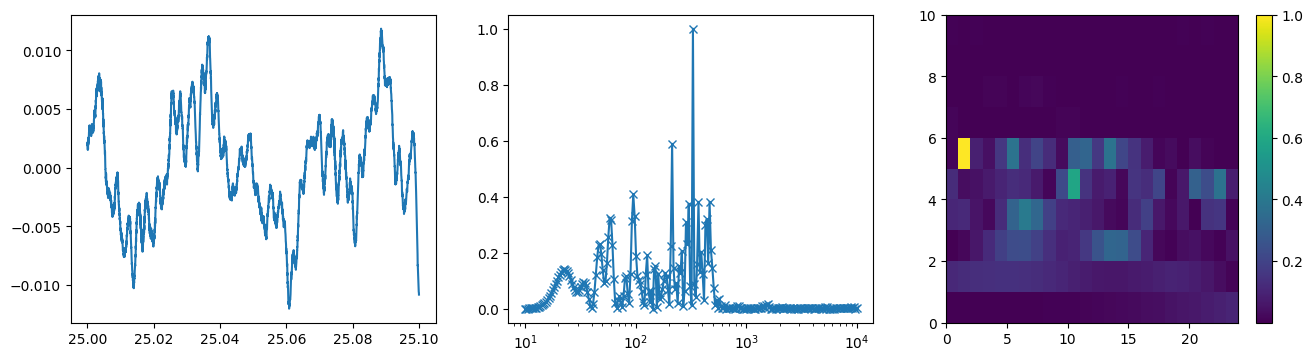

In [ ]:
t=25
logspectrum.spectrum(t=t)
numax = logspectrum.max_freq()
print(f'precision of maximum = {100*(numax-O)/O:.2f}%')
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16,4))
logspectrum.plot_data(ax=ax[0])
logspectrum.plot_spectrum(ax=ax[1], marker='x')
mesh = logspectrum.plot_octaves_2D(ax=ax[2], cmap='viridis')
fig.colorbar(mesh, ax=ax[2])
plt.show()

In [ ]:
peaks_position, _ = find_peaks(logspectrum.spectrum_data)
peaks = np.array([logspectrum.omega[peaks_position], logspectrum.spectrum_data[peaks_position]]).T
sorted_peaks = peaks[peaks[:, 1].argsort()][::-1]
sorted_peaks = sorted_peaks[sorted_peaks[:,1]>0.1*sorted_peaks[0,1]]
sorted_peaks = np.array([sorted_peaks[:,0], sorted_peaks[:,0]/sorted_peaks[0,0], np.log(sorted_peaks[:,1]/sorted_peaks[0,1])/np.log(10)]).T
sorted_peaks

array([[ 3.29376716e+02,  1.00000000e+00,  0.00000000e+00],
       [ 2.13574377e+02,  6.48419777e-01, -2.29973802e-01],
       [ 9.51365692e+01,  2.88838174e-01, -3.89353822e-01],
       [ 4.65809019e+02,  1.41421356e+00, -4.18109236e-01],
       [ 3.69712863e+02,  1.12246205e+00, -4.18583014e-01],
       [ 3.02039780e+02,  9.17004043e-01, -4.25850523e-01],
       [ 5.82261273e+01,  1.76776695e-01, -4.87769320e-01],
       [ 4.39665167e+02,  1.33483985e+00, -4.94278706e-01],
       [ 2.85087590e+02,  8.65536561e-01, -5.10835066e-01],
       [ 4.75682846e+01,  1.44419087e-01, -6.35817181e-01],
       [ 2.61426473e+02,  7.93700526e-01, -6.85354966e-01],
       [ 3.91697134e+02,  1.18920712e+00, -6.92474225e-01],
       [ 1.26992084e+02,  3.85552706e-01, -7.19743070e-01],
       [ 1.51019890e+02,  4.58502022e-01, -8.15250247e-01],
       [ 2.46753732e+02,  7.49153538e-01, -8.21714995e-01],
       [ 2.24492410e+01,  6.81567333e-02, -8.54072816e-01],
       [ 1.84856431e+02,  5.61231024e-01

In [ ]:
peaks

array([[2.24492410e+01, 1.39935268e-01, 2.80000000e+01],
       [3.36358566e+01, 9.39219819e-02, 4.20000000e+01],
       [4.75682846e+01, 2.31303827e-01, 5.40000000e+01],
       [5.82261273e+01, 3.25260016e-01, 6.10000000e+01],
       [7.12718975e+01, 4.47929375e-02, 6.80000000e+01],
       [8.23441789e+01, 1.16362913e-01, 7.30000000e+01],
       [9.51365692e+01, 4.07986862e-01, 7.80000000e+01],
       [1.26992084e+02, 1.90658833e-01, 8.80000000e+01],
       [1.38485850e+02, 6.26032573e-02, 9.10000000e+01],
       [1.51019890e+02, 1.53020548e-01, 9.40000000e+01],
       [1.60000000e+02, 1.24128998e-01, 9.60000000e+01],
       [1.84856431e+02, 1.26742298e-01, 1.01000000e+02],
       [2.13574377e+02, 5.88879178e-01, 1.06000000e+02],
       [2.32904509e+02, 9.12915765e-02, 1.09000000e+02],
       [2.46753732e+02, 1.50759610e-01, 1.11000000e+02],
       [2.61426473e+02, 2.06369273e-01, 1.13000000e+02],
       [2.85087590e+02, 3.08435909e-01, 1.16000000e+02],
       [3.02039780e+02, 3.75102

In [ ]:
t = np.arange(data.shape[0])/sample_rate

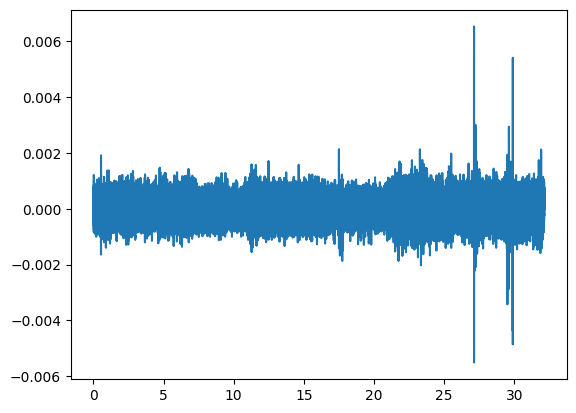

In [ ]:
plt.plot(t, data[:,0])

In [ ]:
logspectrum = LogSpectrum()
logspectrum.nu0 = sample_rate
logspectrum.tint = 0.2 #sec
logspectrum = logspectrum.update()

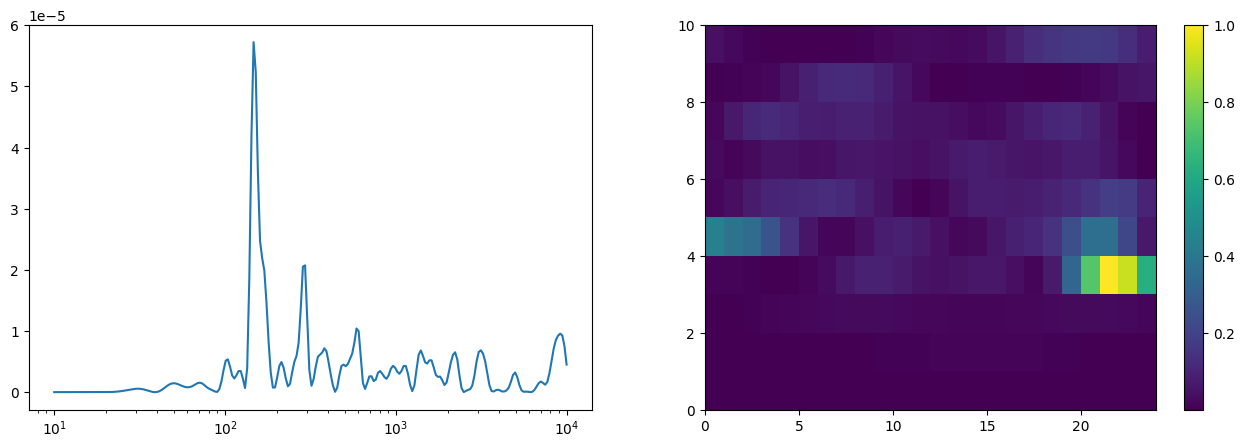

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,5))
ax[0].set_xscale('log')

t=25
res = logspectrum.spectrum(data[int(t*sample_rate):,0])
ax[0].plot(logspectrum.omega, res )
mesh = plot_octaves_2D(logspectrum, res, ax=ax[1], cmap='viridis')
fig.colorbar(mesh, ax=ax[1])
plt.show()

In [ ]:
t=25
res = logspectrum.spectrum(data[int(t*sample_rate):,0])
peaks_position, _ = find_peaks(res)
peaks = np.array([logspectrum.omega[peaks_position], res[peaks_position], peaks_position]).T
sorted_peaks = peaks[peaks[:, 1].argsort()][::-1]
sorted_peaks = sorted_peaks[sorted_peaks[:,1]>0.1*sorted_peaks[0,1]]
sorted_peaks = np.array([sorted_peaks[:,0]/sorted_peaks[0,0], np.log(sorted_peaks[:,1]/sorted_peaks[0,1])/np.log(10), sorted_peaks[:,2]]).T
sorted_peaks

array([[  1.        ,   0.        ,  93.        ],
       [  2.        ,  -0.44089235, 117.        ],
       [  4.        ,  -0.73991832, 141.        ],
       [ 62.17804423,  -0.77681037, 236.        ],
       [  2.59367911,  -0.90151009, 126.        ],
       [ 21.35743767,  -0.92207875, 199.        ],
       [  9.51365692,  -0.92392179, 171.        ],
       [ 15.101989  ,  -0.94326526, 187.        ]])

In [ ]:
tA=time.time()
time_dependent_spectrum = []
tset = []
tmax = 31.1
dt=0.01
for t in np.arange(0,tmax,dt):
    print(f'{t:.1f}/{tmax-dt:.1f} -- {100*t/tmax:.0f}%', end='\r')
    time_dependent_spectrum.append(logspectrum.spectrum(data[int(t*sample_rate):,0]))
    tset.append(t)
time_dependent_spectrum = np.array(time_dependent_spectrum)
print()
print(f'elapsed time = {time.time()-tA:.2f}sec')
    

31.1/31.1 -- 100%
elapsed time = 16.45sec


In [ ]:
time_dependent_spectrum.shape

(3110, 240)

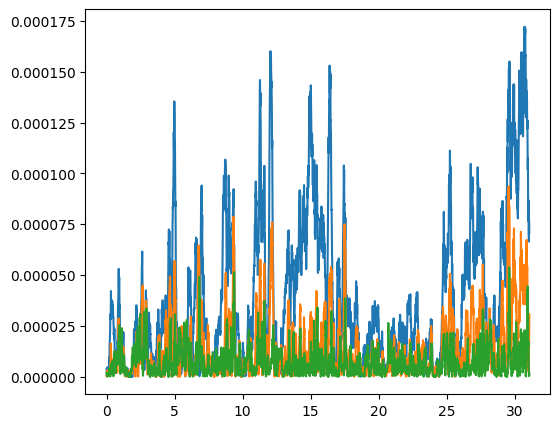

In [ ]:
fig, ax = plt.subplots(ncols=1, figsize=((6,5)))
ax.plot(tset, time_dependent_spectrum[:,93])
ax.plot(tset, time_dependent_spectrum[:,96])
ax.plot(tset, time_dependent_spectrum[:,99])

In [ ]:
import os
os.getcwd()

'/home/jakovac/Work/Mikrofonok'

In [ ]:
len(data[:,0])/sample_rate

32.12913832199546

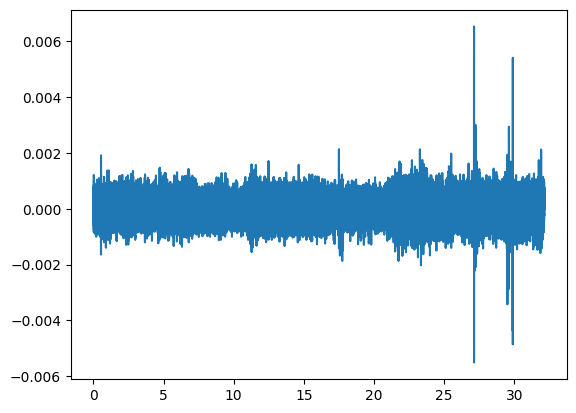

In [ ]:
data, sample_rate = sf.read("szolnok/2025_02_25-17_29_47.wav")
plt.plot(np.arange(len(data[:,0]))/sample_rate, data[:,0])
channel_0_int16 = np.int16(data[:, 0] / np.max(np.abs(data[:, 0])) * 32767)
sd.play(channel_0_int16, samplerate=sample_rate)
sd.wait()  

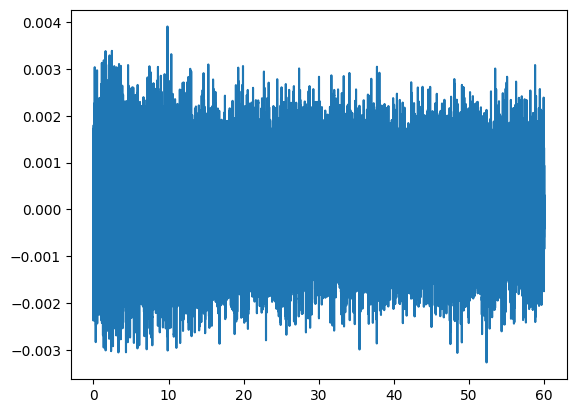

In [ ]:
data, sample_rate = sf.read("szolnok/" + os.listdir("szolnok")[10])
plt.plot(np.arange(len(data[:,0]))/sample_rate, data[:,0])

In [ ]:
logspectrum = LogSpectrum()
logspectrum.nu0 = sample_rate
logspectrum.tint = 0.2 #sec
logspectrum = logspectrum.update()

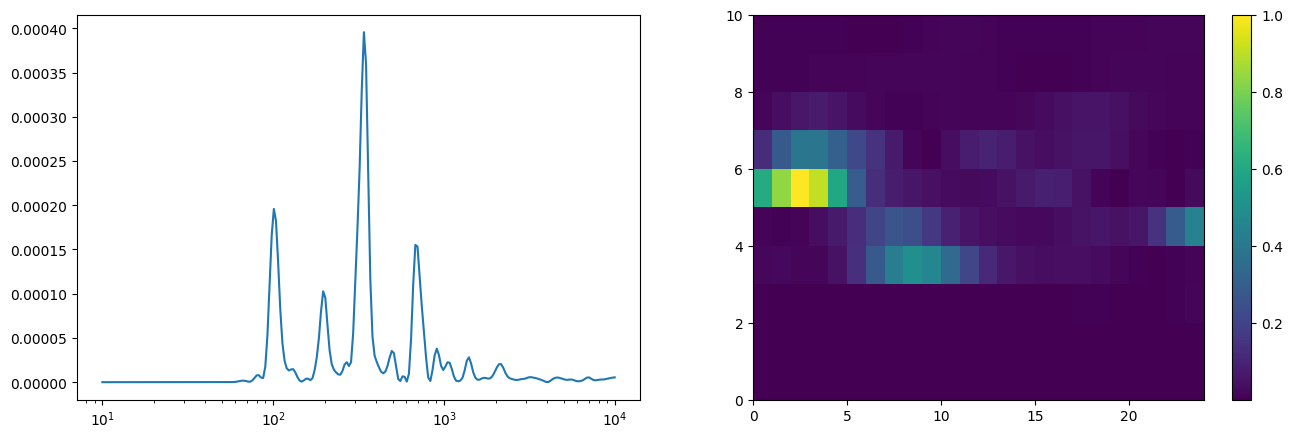

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,5))
ax[0].set_xscale('log')

t=25
res = logspectrum.spectrum(data[int(t*sample_rate):,0])
ax[0].plot(logspectrum.omega, res )
mesh = plot_octaves_2D(logspectrum, res, ax=ax[1], cmap='viridis')
fig.colorbar(mesh, ax=ax[1])
plt.show()

In [ ]:
signal = data[:,0]
channel_0_int16 = np.int16(signal / np.max(np.abs(signal)) * 32767)
sd.play(channel_0_int16[:int(10*sample_rate)], samplerate=sample_rate)
sd.wait() 

In [ ]:
signal = data[:,0]
t = np.arange(len(signal))/sample_rate
# ▶️ Forward Fourier Transform
fft_result = np.fft.fft(signal)

#denoising:
#maxval = np.max(np.abs(fft_result))
#fft_result = [ f if np.abs(f) >5e-3*maxval else 0 for f in fft_result ]

# 🧠 Frequencies corresponding to each FFT bin
freqs = np.fft.fftfreq(len(signal), d=1/sample_rate)

#fft_result = [ fi if np.abs(omegai) <1000 else 0 for fi,omegai in np.array([fft_result, freqs]).T  ]

# 🔁 Inverse Transform (back to time domain)
reconstructed = np.fft.ifft(fft_result).real

# Optional: Plot to compare
#plt.figure(figsize=(10, 4))
#plt.subplot(1, 2, 1)
#plt.plot(t, signal, label="Original")
#plt.plot(t, reconstructed, '--', label="Reconstructed")
#plt.legend()
#
#plt.subplot(1, 2, 2)
#plt.plot(freqs, np.abs(fft_result), label="FFT Magnitude")
#plt.xlim(0, 200)
#plt.legend()
#plt.show()

In [ ]:
signal = reconstructed
channel_0_int16 = np.int16(signal / np.max(np.abs(signal)) * 32767)
sd.play(channel_0_int16[:int(10*sample_rate)], samplerate=sample_rate)
sd.wait()

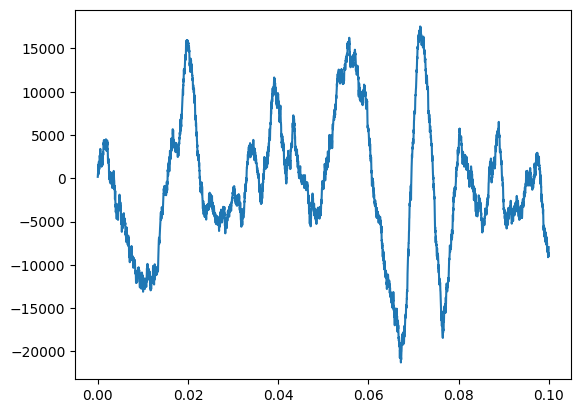

In [ ]:
t0= 10
dt = 0.1
plotdata = channel_0_int16[int(t0*sample_rate):int((t0+dt)*sample_rate)]
tdata = np.arange(len(plotdata))/sample_rate

plt.plot(tdata,plotdata)

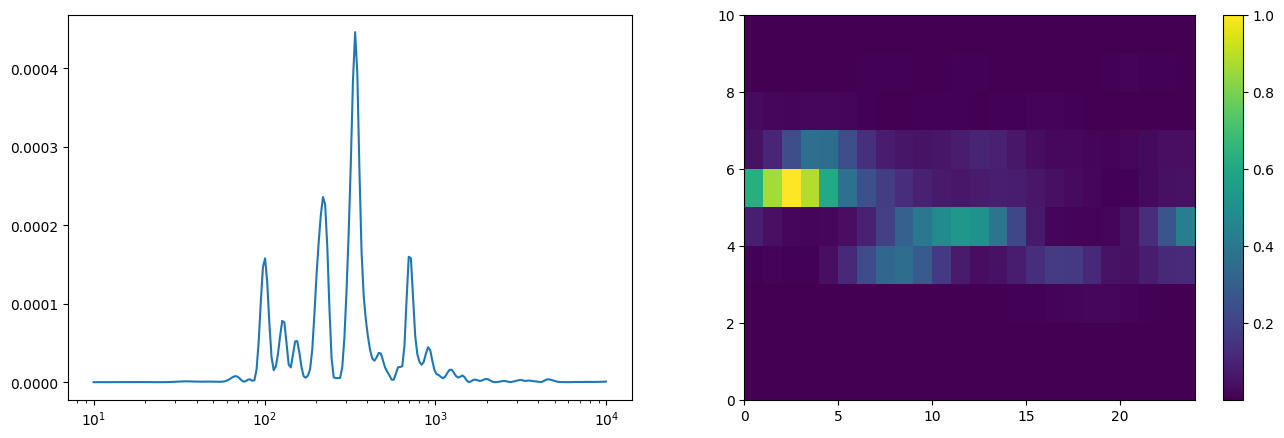

In [ ]:
signal = data[:,0]
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,5))
ax[0].set_xscale('log')

t0 = 10.8
res = logspectrum.spectrum(signal[int(t0*sample_rate):])
ax[0].plot(logspectrum.omega, res )
mesh = plot_octaves_2D(logspectrum, res, ax=ax[1], cmap='viridis')
fig.colorbar(mesh, ax=ax[1])
plt.show()

[0, 1, 0, 0, 0]


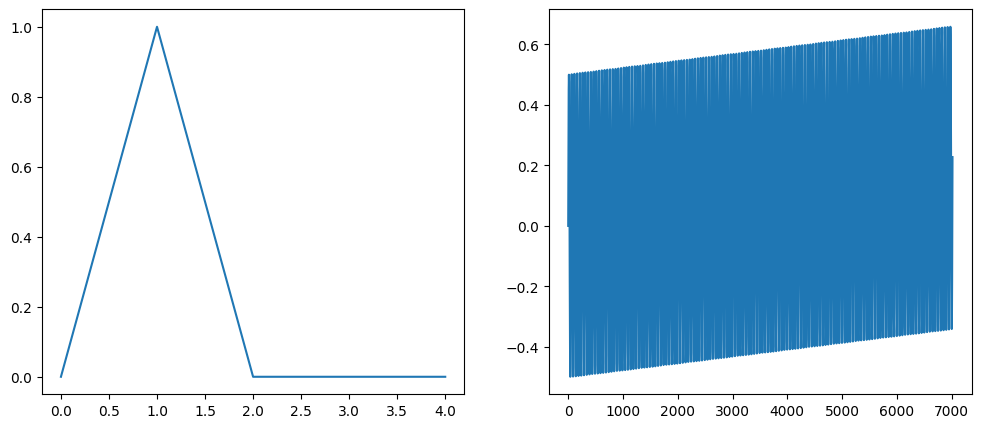

In [ ]:
tmax=3
sample_rate = 44100
t = np.arange(0,tmax,1/sample_rate)
nu0 = 220 #Hz
#np.random.seed(123)
n_components = 5
Vi = np.random.normal(0,1,size=(n_components,))
phi = 0*np.random.uniform(0,2*np.pi,size=(n_components,))
Vi = [0,1,0,0,0]
V = np.empty(shape=t.shape)
for i in range(n_components):
    V += Vi[i]/(i+1)*np.sin(2*np.pi*2**(i+1)*nu0*t + phi[i])
print(Vi)
fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
ax[0].plot(Vi)
ax[1].plot(V[0:int(sample_rate/(2*np.pi))])
plt.show()
signal = V
channel_0_int16 = np.int16(signal / np.max(np.abs(signal)) * 32767)
sd.play(channel_0_int16[:int(10*sample_rate)], samplerate=sample_rate)
sd.wait()

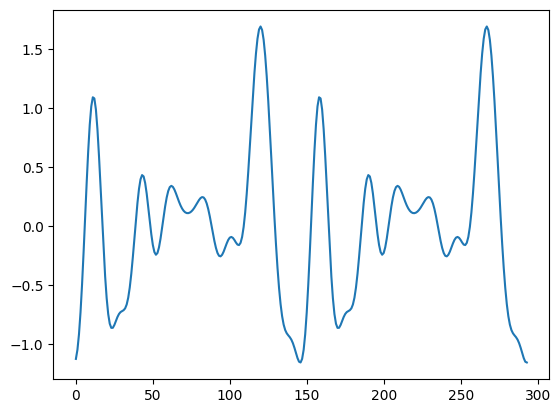

In [ ]:
np.random.seed(124)
n_components = 10
sample_rate = 44100
nu0 = 300 #Hz
nosc = 2
Nplot = int(sample_rate*nosc/nu0)
tmax = 3 #sec
t = np.arange(0,tmax,1/sample_rate)
Ai = [ Vi/(i+1) for i,Vi in enumerate(np.random.normal(0,1,size=(n_components,)))]
#Ai = [ 1/i for i in range(1,n_components+1)]
phi = np.random.uniform(0,2*np.pi,size=(n_components,))
ri = np.array([ np.sin(2*np.pi*(i+1)*nu0*t + phi[i]) for i in range(n_components)])

signal = Ai@ri
plt.plot(signal[:Nplot])
plt.show()

channel_0_int16 = np.int16(signal / np.max(np.abs(signal)) * 32767)
sd.play(channel_0_int16[:int(10*sample_rate)], samplerate=sample_rate)
sd.wait()

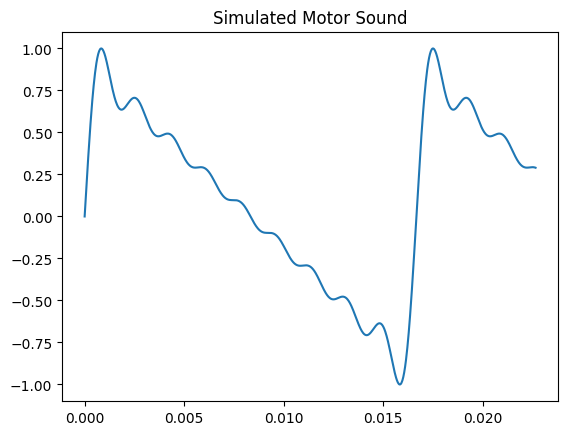

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import sounddevice as sd

# Sampling rate and duration
fs = 44100
duration = 2  # seconds
t = np.linspace(0, duration, int(fs * duration), endpoint=False)

# Base motor frequency (like RPM / 60)
f_base = 60  # 60 Hz = 3600 RPM

# Create harmonics (simulate engine buzz)
motor = np.zeros_like(t)
for i in range(1, 10):
    motor += np.sin(2 * np.pi * f_base * i * t) * (1 / i)  # add harmonics

# Apply amplitude modulation (like revving)
#modulation = 0.5 * (1 + np.sin(2 * np.pi * 2 * t))  # 2 Hz modulation
#motor *= modulation

# Normalize for playback
motor /= np.max(np.abs(motor))

# Listen
sd.play(motor, fs)
sd.wait()

# Optional: visualize
plt.plot(t[:1000], motor[:1000])  # zoom in on waveform
plt.title("Simulated Motor Sound")
plt.show()


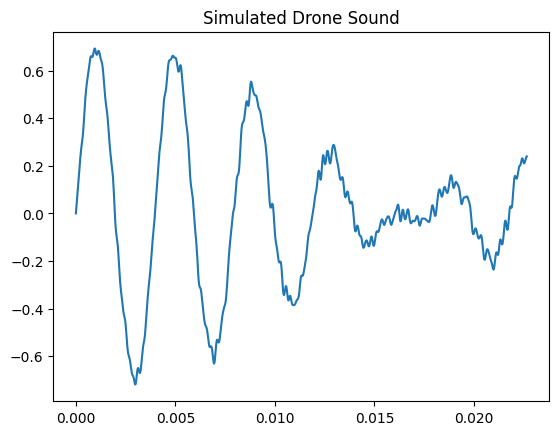

In [ ]:
import numpy as np
import sounddevice as sd
import matplotlib.pyplot as plt

fs = 44100
duration = 2.5  # seconds
t = np.linspace(0, duration, int(fs * duration), endpoint=False)

# Simulate 4 rotors spinning at different base frequencies
rotor_freqs = [230, 245, 260, 275]  # Hz

drone_sound = sum(np.sin(2 * np.pi * f * t) for f in rotor_freqs)

# Add amplitude modulation for flutter
mod = 0.7 + 0.3 * np.sin(2 * np.pi * 10 * t)  # 10 Hz flutter
drone_sound *= mod

# Add filtered noise (blade hiss)
noise = 0.2 * np.random.randn(len(t))
# Apply a simple low-pass filter
from scipy.signal import butter, lfilter
b, a = butter(6, 0.2)
filtered_noise = lfilter(b, a, noise)

# Mix it in
drone_sound += filtered_noise

# Normalize
drone_sound /= np.max(np.abs(drone_sound))

# Listen
sd.play(drone_sound, fs)
sd.wait()

# Optional: Plot a small snippet
plt.plot(t[:1000], drone_sound[:1000])
plt.title("Simulated Drone Sound")
plt.show()


In [ ]:
1.1**10

2.5937424601000023

In [ ]:
import ffmpeg

input_file = 'data/Drone Noise Test - DJI Avata vs DJI FPV vs DJI Mavic 3 vs DJI Air 2S compared.mp4'
output_file = 'output_audio.wav'

ffmpeg.input(input_file).output(output_file, **{'q:a': 0, 'map': 'a'}).run()


ffmpeg version 6.1.1-3ubuntu5 Copyright (c) 2000-2023 the FFmpeg developers
  built with gcc 13 (Ubuntu 13.2.0-23ubuntu3)
  configuration: --prefix=/usr --extra-version=3ubuntu5 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --disable-omx --enable-gnutls --enable-libaom --enable-libass --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libglslang --enable-libgme --enable-libgsm --enable-libharfbuzz --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-libzimg --ena

(None, None)